In [6]:
model.save('model_unet.h5')

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. Obtain ILO images.
2. Convert ILO images to PNG format.
3. Segment lungs in the PNG images.
4. Separate left and right lung parts.
5. Divide each lung part into 6 sub-parts.
6. Compute the features of each sub-part and find their correlation with other sub-parts using appropriate metrics.
7. Create a graph for each sub-part, where the nodes represent the sub-parts and the edges represent their correlations.
8. Use graph matching to create a dataset for training the GNN, where each sample in the dataset consists of two graphs (one from a standard image and one from an input image) and a label indicating whether they match.
9. Save the similarity score for each pair of graphs in the dataset as the label or class.
10. Train the GNN on the dataset using supervised learning, where the input is a pair of graphs and the output is a label or class.

In [1]:
import numpy as np
import cv2,os
import matplotlib.pyplot as plt

mask = cv2.imread('segmented_lungs/11_pp.png', cv2.IMREAD_GRAYSCALE)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
left_lung_pixels = np.zeros_like(mask)
right_lung_pixels = np.zeros_like(mask)
for i, centroid in enumerate(centroids[1:], start=1):
    if centroid[0] < mask.shape[1] // 2:
        left_lung_pixels[labels == i] = mask[labels == i]
        x, y, w, h = cv2.boundingRect(left_lung_pixels)

        # Divide the image into six parts
        part_width = w // 2
        part_height = h // 3
        
        left_left_upper = mask[y:y+part_height, x:x+part_width]
        left_left_middle = mask[y+part_height:y+2*part_height, x:x+part_width]
        left_left_bottom = mask[y+2*part_height:y+3*part_height, x:x+part_width]
        left_right_upper = mask[y:y+part_height, x+part_width:x+2*part_width]
        left_right_middle = mask[y+part_height:y+2*part_height, x+part_width:x+2*part_width]
        left_right_bottom = mask[y+2*part_height:y+3*part_height, x+part_width:x+2*part_width]
    else:
        right_lung_pixels[labels == i] = mask[labels == i]
        x, y, w, h = cv2.boundingRect(right_lung_pixels)

        # Divide the image into six parts
        part_width = w // 2
        part_height = h // 3
        
        right_left_upper = mask[y:y+part_height, x:x+part_width]
        right_left_middle = mask[y+part_height:y+2*part_height, x:x+part_width]
        right_left_bottom = mask[y+2*part_height:y+3*part_height, x:x+part_width]
        right_right_upper = mask[y:y+part_height, x+part_width:x+2*part_width]
        right_right_middle = mask[y+part_height:y+2*part_height, x+part_width:x+2*part_width]
        right_right_bottom = mask[y+2*part_height:y+3*part_height, x+part_width:x+2*part_width]


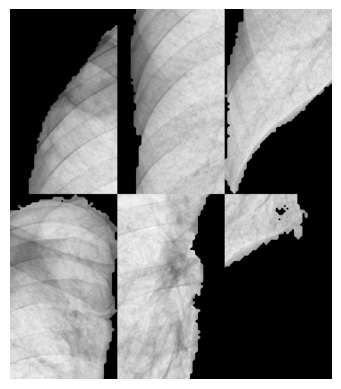

In [3]:
left_lung = np.vstack([
    np.hstack([left_left_upper, left_left_middle, left_left_bottom]),
    np.hstack([left_right_upper, left_right_middle, left_right_bottom])
])

# Plot the combined left lung image
plt.imshow(left_lung, cmap='gray')
plt.axis('off')
plt.show()

In [41]:
import networkx as nx
graph_r = nx.DiGraph()

In [42]:
graph_r.add_nodes_from(['right_left_upper' ,'right_left_middle','right_left_bottom', 'right_right_upper','right_right_middle' , 'right_right_bottom'])
pos = {'right_left_upper': (0, 1), 'right_left_middle': (0, 0.5), 'right_left_bottom': (0, 0),
       'right_right_upper': (1, 1), 'right_right_middle': (1, 0.5), 'right_right_bottom': (1, 0)}

In [47]:
graph_r.add_edges_from([('right_left_middle', 'right_left_bottom'),('right_left_upper', 'right_left_middle'),
                      ('right_left_upper', 'right_right_upper'),('right_left_middle', 'right_right_middle'), 
                      ('right_left_bottom', 'right_right_bottom'),('right_left_middle', 'right_left_bottom'), 
                      ('right_right_middle', 'right_right_bottom'),('right_right_upper','right_right_middle')])

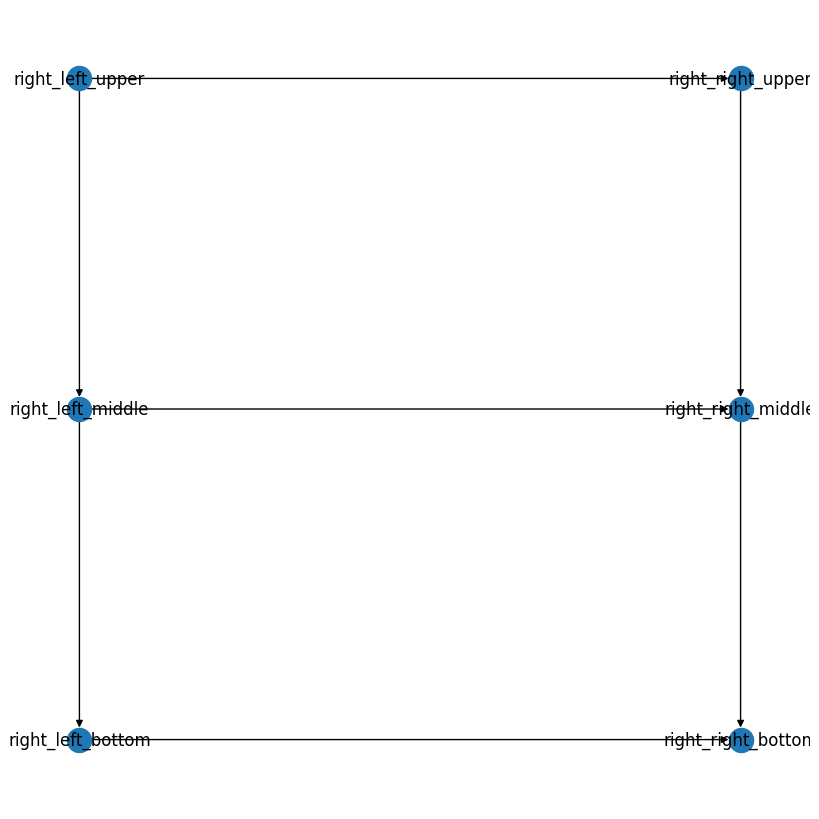

In [48]:
plt.figure(3,figsize=(8,8)) 
nx.draw(graph_r,pos=pos, with_labels=True)
plt.show()

In [45]:
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops


# loop over each lung region
for node_id,lung_part in zip(graph_r.nodes,right_lungs):
    # print(node_id)
    # node_name = graph_r.nodes[node_id]['name']
    # sub_mask = graph_r.nodes[node_id]['mask']
    
    # extract texture features from GLCM
    glcm = graycomatrix(lung_part, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0][0]
    correlation = graycoprops(glcm, 'correlation')[0][0]
    energy = graycoprops(glcm, 'energy')[0][0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
    
    # add texture features to the node
    graph_r.nodes[node_id]['contrast'] = contrast
    graph_r.nodes[node_id]['correlation'] = correlation
    graph_r.nodes[node_id]['energy'] = energy
    graph_r.nodes[node_id]['homogeneity'] = homogeneity

    # Shape Features
    props = regionprops(lung_part)
    area = props[0].area
    # perimeter = props[0].perimeter
    # if perimeter != 0:
        # circularity = (4*np.pi*area) / (perimeter**2)
    # else:
        # circularity = 0.0
    eccentricity = props[0].eccentricity
    graph_r.nodes[node_id]['area'] = area
    # graph_r.nodes[node_id]['perimeter'] = perimeter
    # graph_r.nodes[node_id]['circularity'] = circularity
    graph_r.nodes[node_id]['eccentricity'] = eccentricity


In [49]:
betweenness = nx.betweenness_centrality(graph_r)

# Print the betweenness centrality for each node
for node, centrality in betweenness.items():
    print(f"Node {node}: Betweenness Centrality = {centrality}")

Node right_left_upper: Betweenness Centrality = 0.0
Node right_left_middle: Betweenness Centrality = 0.10833333333333334
Node right_left_bottom: Betweenness Centrality = 0.041666666666666664
Node right_right_upper: Betweenness Centrality = 0.041666666666666664
Node right_right_middle: Betweenness Centrality = 0.10833333333333334
Node right_right_bottom: Betweenness Centrality = 0.0


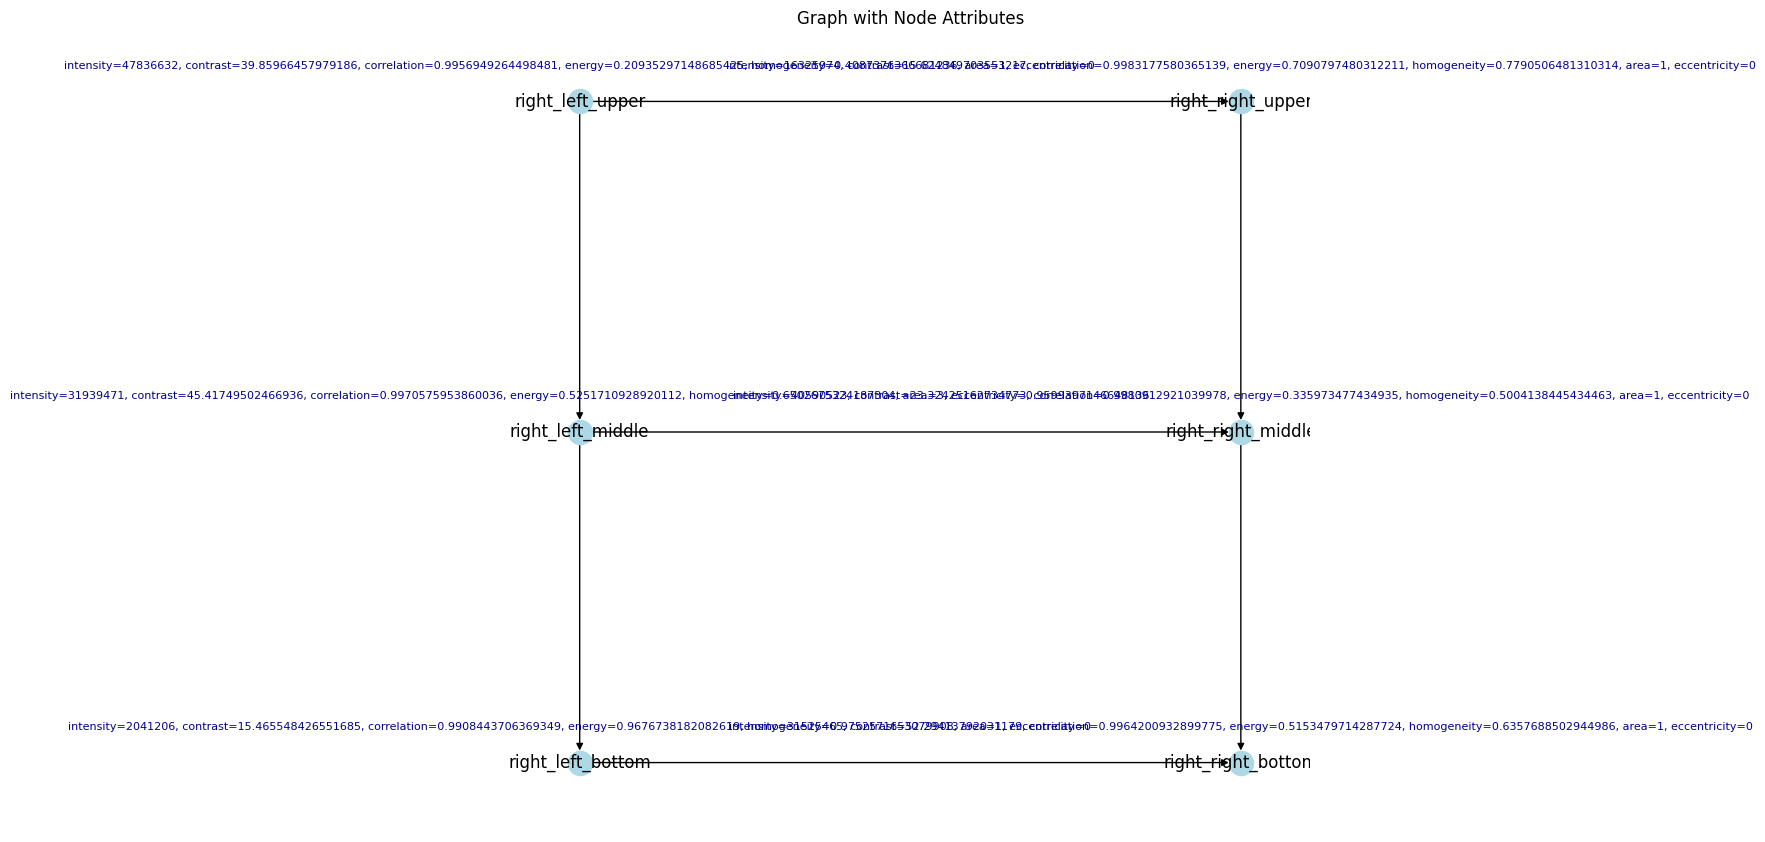

In [32]:
# Create a new figure for plotting
plt.figure(figsize=(8, 8))

# Draw the graph with node labels and attribute values
# pos = nx.draw(graph_r)  # Define the layout for the nodes
nx.draw(graph_r, pos, with_labels=True, node_size=300, node_color='lightblue', font_color='black')

# Iterate over the nodes and their attributes
for node, attr in graph_r.nodes(data=True):
    # Get the attribute values
    attributes = ', '.join(f"{key}={value}" for key, value in attr.items())
    
    # Draw the attribute values as labels near the corresponding nodes
    x, y = pos[node]
    plt.text(x, y + 0.05, attributes, ha='center', fontsize=8, color='darkblue')

# Set the plot title and display the graph
plt.title('Graph with Node Attributes')
plt.axis('off')
plt.show()

In [11]:
graph_r.nodes(data=True)

NodeDataView({'right_left_upper': {'intensity': 47836632, 'contrast': 39.85966457979186, 'correlation': 0.9956949264498481, 'energy': 0.20935297148685425, 'homogeneity': 0.4087376366681236, 'area': 1, 'eccentricity': 0}, 'right_left_middle': {'intensity': 31939471, 'contrast': 45.41749502466936, 'correlation': 0.9970575953860036, 'energy': 0.5251710928920112, 'homogeneity': 0.6502675324187304, 'area': 3, 'eccentricity': 0.9599397146648136}, 'right_left_bottom': {'intensity': 2041206, 'contrast': 15.465548426551685, 'correlation': 0.9908443706369349, 'energy': 0.9676738182082619, 'homogeneity': 0.9752571653079908, 'area': 1, 'eccentricity': 0}, 'right_right_upper': {'intensity': 16325974, 'contrast': 15.624849703553217, 'correlation': 0.9983177580365139, 'energy': 0.7090797480312211, 'homogeneity': 0.7790506481310314, 'area': 1, 'eccentricity': 0}, 'right_right_middle': {'intensity': 40590523, 'contrast': 23.32425162734773, 'correlation': 0.9980912921039978, 'energy': 0.335973477434935,

In [50]:
betweenness_centrality_values = {
    "right_left_upper": 0.0,
    "right_left_middle": 0.10833333333333334,
    "right_left_bottom": 0.041666666666666664,
    "right_right_upper": 0.041666666666666664,
    "right_right_middle": 0.10833333333333334,
    "right_right_bottom": 0.0
}

# Update the node attributes with betweenness centrality values
for node in graph_r.nodes:
    betweenness = nx.betweenness_centrality(graph_r)
    graph_r.nodes[node]['betweenness_centrality'] = betweenness_centrality_values.get(node, 0.0)

In [120]:
all_images = 'indian_data_tb_normal/images/'

Tuberculosis    78
False           77
Name: findings, dtype: int64

Predict the mask

In [7]:
import os,cv2
import numpy as np
path = 'final/1/'
segmented_path = 'final/mask/'
segmentedLung_path = 'final/seg/1/'
images = os.listdir(path)
for i in range(len(images)):
    ## Covert image to equlized
    # if 'px' in images[i]:
    img = cv2.imread(path+images[i],1)
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # apply histogram equalization
    #print("[INFO] performing histogram equalization...")
    #equalized = cv2.equalizeHist(gray)
    #print('[INFO] Convert image to RGB channel')
    # img = cv2.cvtColor(equalized,cv2.COLOR_GRAY2BGR)
    pred = model.predict_segmentation(
        inp=img,
        out_fname=segmented_path+images[i],
        class_names=["background","lungs"]
    )
    del pred
    ##Load mask
    mask = cv2.imread(segmented_path+images[i],0)
    _, mask = cv2.threshold(mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
    img = img[:,:,0]
    segmented = img*mask
    cv2.imwrite(segmentedLung_path+images[i],segmented)
    

1/1 [==============================] - 1s 810ms/step


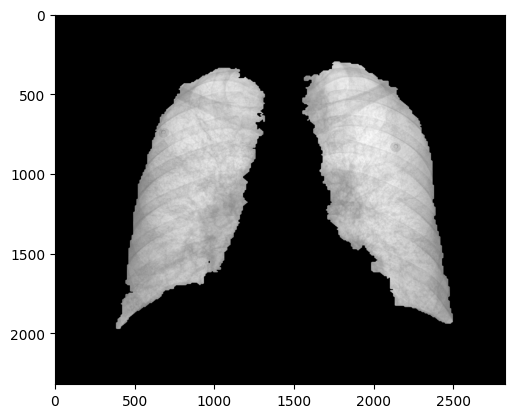

In [22]:
plt.imshow(segmented,cmap='gray')

In [18]:
# Reshape the mask to be 2D


In [15]:
standard_class = 'png_images/'
all_images = 'data/old_1/'

In [8]:
import cv2,os
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern
from skimage.filters import gabor
import matplotlib.pyplot as plt

In [30]:

def parts_data(image):
    image_parts = []
    mask = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    left_lung_pixels = np.zeros_like(mask)
    right_lung_pixels = np.zeros_like(mask)
    left_lungs = []
    right_lungs = []
    for i, centroid in enumerate(centroids[1:], start=1):
        if centroid[0] < mask.shape[1] // 2:
            left_lung_pixels[labels == i] = mask[labels == i]
            x, y, w, h = cv2.boundingRect(left_lung_pixels)
    
            # Divide the image into six parts
            part_width = w // 2
            part_height = h // 3
            
            left_left_upper = mask[y:y+part_height, x:x+part_width]
            left_left_middle = mask[y+part_height:y+2*part_height, x:x+part_width]
            left_left_bottom = mask[y+2*part_height:y+3*part_height, x:x+part_width]
            left_right_upper = mask[y:y+part_height, x+part_width:x+2*part_width]
            left_right_middle =mask[y+part_height:y+2*part_height, x+part_width:x+2*part_width]
            left_right_bottom =mask[y+2*part_height:y+3*part_height, x+part_width:x+2*part_width]
            
        else:
            right_lung_pixels[labels == i] = mask[labels == i]
            x, y, w, h = cv2.boundingRect(right_lung_pixels)
    
            # Divide the image into six parts
            part_width = w // 2
            part_height = h // 3
            
            right_left_upper = mask[y:y+part_height, x:x+part_width]
            right_left_middle = mask[y+part_height:y+2*part_height, x:x+part_width]
            right_left_bottom = mask[y+2*part_height:y+3*part_height, x:x+part_width]
            right_right_upper = mask[y:y+part_height, x+part_width:x+2*part_width]
            right_right_middle = mask[y+part_height:y+2*part_height, x+part_width:x+2*part_width]
            right_right_bottom = mask[y+2*part_height:y+3*part_height, x+part_width:x+2*part_width]

    left_lungs.extend([left_left_upper,  left_left_middle, left_left_bottom
               ,left_right_upper,left_right_middle, left_right_bottom])
    image_parts.append(left_lungs)
    right_lungs.extend([right_left_upper,  right_left_middle, right_left_bottom
               ,right_right_upper,right_right_middle, right_right_bottom])
    image_parts.append(right_lungs)
            
    return image_parts

In [130]:
def parts_data(image):
    image_parts = []
    mask = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    left_lung_pixels = np.zeros_like(mask)
    right_lung_pixels = np.zeros_like(mask)
    left_lungs = []
    right_lungs = []
    for i, centroid in enumerate(centroids[1:], start=1):
        if centroid[0] < mask.shape[1] // 2:
            left_lung_pixels[labels == i] = mask[labels == i]
            x, y, w, h = cv2.boundingRect(left_lung_pixels)
    
            # Divide the image into six parts
            part_width = w // 2
            part_height = h // 3
            
            left_left_upper = mask[y:y+part_height, x:x+part_width]
            left_left_middle = mask[y+part_height:y+2*part_height, x:x+part_width]
            left_left_bottom = mask[y+2*part_height:y+3*part_height, x:x+part_width]
            left_right_upper = mask[y:y+part_height, x+part_width:x+2*part_width]
            left_right_middle =mask[y+part_height:y+2*part_height, x+part_width:x+2*part_width]
            left_right_bottom =mask[y+2*part_height:y+3*part_height, x+part_width:x+2*part_width]
            
            left_lungs.extend([left_left_upper, left_left_middle, left_left_bottom,
                               left_right_upper, left_right_middle, left_right_bottom])
        else:
            right_lung_pixels[labels == i] = mask[labels == i]
            x, y, w, h = cv2.boundingRect(right_lung_pixels)
    
            # Divide the image into six parts
            part_width = w // 2
            part_height = h // 3
            
            right_left_upper = mask[y:y+part_height, x:x+part_width]
            right_left_middle = mask[y+part_height:y+2*part_height, x:x+part_width]
            right_left_bottom = mask[y+2*part_height:y+3*part_height, x:x+part_width]
            right_right_upper = mask[y:y+part_height, x+part_width:x+2*part_width]
            right_right_middle = mask[y+part_height:y+2*part_height, x+part_width:x+2*part_width]
            right_right_bottom = mask[y+2*part_height:y+3*part_height, x+part_width:x+2*part_width]

            right_lungs.extend([right_left_upper, right_left_middle, right_left_bottom,
                                right_right_upper, right_right_middle, right_right_bottom])
    
    # Check if left or right parts are missing and create image parts with 0 pixels
    if len(left_lungs) == 0:
        left_lungs = [np.zeros_like(mask)] * 6
    if len(right_lungs) == 0:
        right_lungs = [np.zeros_like(mask)] * 6

    image_parts.append(left_lungs)
    image_parts.append(right_lungs)
            
    return image_parts


In [31]:
import networkx as nx
def graphs():
        graph_l = nx.DiGraph()
        graph_l.add_nodes_from(['left_left_upper' ,'left_left_middle','left_left_bottom', 'left_right_upper','left_right_middle' , 'left_right_bottom'])
        # pos = {'left_left_upper': (0, 1), 'left_left_middle': (0, 0.5), 'left_left_bottom': (0, 0),
#        'left_right_upper': (1, 1), 'left_right_middle': (1, 0.5), 'left_right_bottom': (1, 0)} 
        graph_l.add_edges_from([('left_left_middle', 'left_left_bottom'),('left_left_upper', 'left_left_middle'),
                      ('left_left_upper', 'left_right_upper'),('left_left_middle', 'left_right_middle'), 
                      ('left_left_bottom', 'left_right_bottom'),('left_left_middle', 'left_left_bottom'), 
                      ('left_right_middle', 'left_right_bottom'),('left_right_upper','left_right_middle')])
        graph_r = nx.DiGraph()
        graph_r.add_nodes_from(['right_left_upper' ,'right_left_middle','right_left_bottom', 'right_right_upper','right_right_middle' , 'right_right_bottom'])
        # pos = {'right_left_upper': (0, 1), 'right_left_middle': (0, 0.5), 'right_left_bottom': (0, 0),
#        'right_right_upper': (1, 1), 'right_right_middle': (1, 0.5), 'right_right_bottom': (1, 0)} 
        graph_r.add_edges_from([('right_left_middle', 'right_left_bottom'),('right_left_upper', 'right_left_middle'),
                      ('right_left_upper', 'right_right_upper'),('right_left_middle', 'right_right_middle'), 
                      ('right_left_bottom', 'right_right_bottom'),('right_left_middle', 'right_left_bottom'), 
                      ('right_right_middle', 'right_right_bottom'),('right_right_upper','right_right_middle')])
        return [graph_l,graph_r]

In [4]:
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops
import cv2,os
import numpy as np


def feature_graph(image):

    image_parts = parts_data(image)
    graph_parts = graphs()
    feature_graphs = []
    for graph,lung_parts in zip(graph_parts,image_parts):
        betweenness = nx.betweenness_centrality(graph) 
        # loop over each lung region
        for node_id,lung_part in zip(graph,lung_parts):
            # print(node_id)
            # extract texture features from GLCM
            glcm = graycomatrix(lung_part, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0][0]
            correlation = graycoprops(glcm, 'correlation')[0][0]
            energy = graycoprops(glcm, 'energy')[0][0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
            
            # add texture features to the node
            graph.nodes[node_id]['contrast'] = contrast
            graph.nodes[node_id]['correlation'] = correlation
            graph.nodes[node_id]['energy'] = energy
            graph.nodes[node_id]['homogeneity'] = homogeneity
        
            # Shape Features
            props = regionprops(lung_part)
            if props:
                area = props[0].area
                eccentricity = props[0].eccentricity
            else:
                area = 0.0
                eccentricity = 0.0
            graph.nodes[node_id]['area'] = area
            graph.nodes[node_id]['eccentricity'] = eccentricity
            graph.nodes[node_id]['betweenness_centrality'] = betweenness.get(node_id, 0.0)
        feature_graphs.append(graph)
    return feature_graphs
    

In [32]:
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops
import cv2,os
import numpy as np
def feature_graph(image):
    image_parts = parts_data(image)
    graph_parts = graphs()
    feature_graphs = []
    for graph, lung_parts in zip(graph_parts, image_parts):
        betweenness = nx.betweenness_centrality(graph) 
        # loop over each lung region
        for node_id, lung_part in zip(graph, lung_parts):
            # Check if the lung part is an empty array
            if np.sum(lung_part) == 0:
                # Set all features to 0
                contrast = 0.0
                correlation = 0.0
                energy = 0.0
                homogeneity = 0.0
                area = 0.0
                eccentricity = 0.0
            else:
                # extract texture features from GLCM
                glcm = graycomatrix(lung_part, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0][0]
                correlation = graycoprops(glcm, 'correlation')[0][0]
                energy = graycoprops(glcm, 'energy')[0][0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
            
                # Shape Features
                props = regionprops(lung_part)
                if props:
                    area = props[0].area
                    eccentricity = props[0].eccentricity
                else:
                    area = 0.0
                    eccentricity = 0.0
            
            # add texture and shape features to the node
            graph.nodes[node_id]['contrast'] = contrast
            graph.nodes[node_id]['correlation'] = correlation
            graph.nodes[node_id]['energy'] = energy
            graph.nodes[node_id]['homogeneity'] = homogeneity
            graph.nodes[node_id]['area'] = area
            graph.nodes[node_id]['eccentricity'] = eccentricity
            graph.nodes[node_id]['betweenness_centrality'] = betweenness.get(node_id, 0.0)
        
        feature_graphs.append(graph)
    
    return feature_graphs


In [ ]:
#Feature Graph call on dataframe of validation image 

In [89]:
image = 'segmented_lungs/33_ss.png'
feature_graphs = feature_graph(image)

In [133]:
standard_images = {
    'Abnormal': ['classes/11_pp.png', 'classes/22_pp.png','classes/33_pp.png',
                 'classes/11_qq.png', 'classes/22_qq.png','classes/33_qq.png',
                 'classes/11_rr.png', 'classes/22_rr.png','classes/33_rr.png',
                'classes/11_ss.png', 'classes/22_ss.png','classes/33_ss.png'],
    'Normal':['classes/normal.png']
}

In [134]:
validation_stanadrd = {
    'Normal':['sms_lungs/00_1.jpg','sms_lungs/00_2_es.jpg','sms_lungs/00_3.jpg'
              ,'sms_lungs/00_4.jpg','sms_lungs/00_5.jpg','sms_lungs/00_6.jpg'],
    'Abnormal':['sms_lungs/11_qq_1.jpg','sms_lungs/11_qq_2.jpg','sms_lungs/22_qq_3.jpg',
                 'sms_lungs/22_qq_5.jpg','sms_lungs/33_qq_1.jpg','sms_lungs/33_qq_6.jpg',
                 'sms_lungs/33_qq_PMF A.jpg','sms_lungs/33_rr_1.jpg','sms_lungs/33_rr_2.jpg',
                 'sms_lungs/33_rr_3.jpg','sms_lungs/33_rr_7.jpg','sms_lungs/33_rr_B_es.jpg',
                 'sms_lungs/33_rr_PMF B.jpg','sms_lungs/33_rr_cv.jpg',
                 'sms_lungs/33_rr_px.jpg','sms_lungs/33_rr_tb.jpg','sms_lungs/PMF_C.jpg',
                 'sms_lungs/Pleural Plaque_left side.jpg','sms_lungs/pp_22.jpg','sms_lungs/qq_22.jpg',
                 'sms_lungs/qq_22_es.jpg','sms_lungs/rr_22_1.jpg','sms_lungs/rr_22_2.jpg',
                 'sms_lungs/rr_22_3.jpg','sms_lungs/rr_22_4.jpg','sms_lungs/rr_33_4.jpg',
                 'sms_lungs/ss_22_1.jpg','sms_lungs/tt_22.jpg','sms_lungs/uu_33.jpg']
}

In [33]:
import pandas as pd
test_data = []
image_directory = 'hospital_segment/seg/0/'
dataset_images = os.listdir('hospital_segment/seg/0/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    test_data.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
test_df_0 = pd.DataFrame(test_data)
test_df_0['class_label'] = ['Normal']*test_df_0.shape[0] 


test_data = []
image_directory = 'hospital_segment/seg/1/'
dataset_images = os.listdir('hospital_segment/seg/1/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    test_data.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
test_df_1 = pd.DataFrame(test_data)
test_df_1['class_label'] = ['Abnormal']*test_df_1.shape[0] 

In [35]:
data2_data = []
image_directory = 'indian_data_tb_normal/normal_seg/'
dataset_images = os.listdir('indian_data_tb_normal/normal_seg/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    data2_data.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
indian_df_0 = pd.DataFrame(data2_data)
indian_df_0['class_label'] = ['Normal']*indian_df_0.shape[0] 

In [145]:
indian_df_0 = pd.DataFrame(data2_data)
indian_df_0['class_label'] = ['Normal']*indian_df_0.shape[0] 

In [198]:
import pandas as pd
import cv2


data = []
for class_label, images in validation_stanadrd.items():
    for image in images:
        print(image)
        feature_graphs = feature_graph(image)
        left_graph = feature_graphs[0]
        right_graph = feature_graphs[1]
        # data.append({'image_id':image.split('/')[1], 'left_graph': left_graph, 'right_graph': right_graph,'class_label': class_label})
        data.append({'image_id':image, 'left_graph': left_graph, 'right_graph': right_graph,'class_label': class_label})

standard_df = pd.DataFrame(data)

sms_lungs/00_1.jpg
sms_lungs/00_2_es.jpg
sms_lungs/00_3.jpg
sms_lungs/00_4.jpg
sms_lungs/00_5.jpg
sms_lungs/00_6.jpg
sms_lungs/11_qq_1.jpg
sms_lungs/11_qq_2.jpg
sms_lungs/22_qq_3.jpg
sms_lungs/22_qq_5.jpg
sms_lungs/33_qq_1.jpg
sms_lungs/33_qq_6.jpg
sms_lungs/33_qq_PMF A.jpg
sms_lungs/33_rr_1.jpg
sms_lungs/33_rr_2.jpg
sms_lungs/33_rr_3.jpg
sms_lungs/33_rr_7.jpg
sms_lungs/33_rr_B_es.jpg
sms_lungs/33_rr_PMF B.jpg
sms_lungs/33_rr_cv.jpg
sms_lungs/33_rr_px.jpg
sms_lungs/33_rr_tb.jpg
sms_lungs/PMF_C.jpg
sms_lungs/Pleural Plaque_left side.jpg
sms_lungs/pp_22.jpg
sms_lungs/qq_22.jpg
sms_lungs/qq_22_es.jpg
sms_lungs/rr_22_1.jpg
sms_lungs/rr_22_2.jpg
sms_lungs/rr_22_3.jpg
sms_lungs/rr_22_4.jpg
sms_lungs/rr_33_4.jpg
sms_lungs/ss_22_1.jpg
sms_lungs/tt_22.jpg
sms_lungs/uu_33.jpg


In [111]:
import pandas as pd
test_data = []
image_directory = 'final/seg/0/'
dataset_images = os.listdir('final/seg/0/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    test_data.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
test_df_0 = pd.DataFrame(test_data)
test_df_0['class_label'] = ['Normal']*test_df_0.shape[0] 


In [116]:
test_data = []
image_directory = 'final/seg/1/'
dataset_images = os.listdir('final/seg/1/') 
# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    print(image_id)
    if image_id in  ['283.jpg','18574.jpg']:
        continue
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    test_data.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
test_df_1 = pd.DataFrame(test_data)
test_df_1['class_label'] = ['Abnormal']*test_df_1.shape[0]

11760.jpg


4135.jpg
22_qq_5.jpg
20232.jpg
14980.jpg
18245.jpg
B_23_qr.png
21347.jpg
14611.jpg
283.jpg
3822.jpg
18574.jpg
14976.jpg
4425.jpg
14061.jpg
6577.jpg
16904.jpg
497.jpg
9627.jpg
3851.jpg
2019.jpg
17482.jpg
Pleural Plaque_left side.jpg
13504.jpg
33_ts.png
22_qq.png
7038.jpg
14310.jpg
19557.jpg
2506.jpg
17575.jpg
931.jpg
10602.jpg
22157.jpg
1525.jpg
9038.jpg
2430.jpg
440.jpg
17982.jpg
16696.jpg
5929.jpg
19436.jpg
2107.jpg
11_qq.png
18399.jpg
14831.jpg
14613.jpg
19334.jpg
13659.jpg
17286.jpg
17968.jpg
8773.jpg
33_qq_PMF A.jpg
21798.jpg
16661.jpg
13519.jpg
7043.jpg
15617.jpg
12876.jpg
19300.jpg
4529.jpg
10427.jpg
tt_22.jpg
10066.jpg
16517.jpg
14605.jpg
12599.jpg
14488.jpg
12683.jpg
16406.jpg
22_qq_3.jpg
9481.jpg
3631.jpg
qq_22.jpg
8425.jpg
12137.jpg
33_rr_B_es.jpg
5932.jpg
rr_22_2.jpg
21224.jpg
2707.jpg
10627.jpg
991.jpg
uu_33.jpg
279.jpg
4036.jpg
8002.jpg
4404.jpg
9329.jpg
13144.jpg
9455.jpg
22_ss.png
18654.jpg
15643.jpg
10513.jpg
rr_22_3.jpg
20059.jpg
11307.jpg
33_ss.png
3948.jpg
5644.jpg
1

In [199]:
import pandas as pd

data = []
for class_label, images in standard_images.items():
    for image in images:
        print(image)
        feature_graphs = feature_graph(image)
        left_graph = feature_graphs[0]
        right_graph = feature_graphs[1]
        # data.append({'image_id':image.split('/')[1], 'left_graph': left_graph, 'right_graph': right_graph,'class_label': class_label})
        data.append({'image_id':image, 'left_graph': left_graph, 'right_graph': right_graph,'class_label': class_label})


df = pd.DataFrame(data)

classes/11_pp.png


classes/22_pp.png
classes/33_pp.png
classes/11_qq.png
classes/22_qq.png
classes/33_qq.png
classes/11_rr.png
classes/22_rr.png
classes/33_rr.png
classes/11_ss.png
classes/22_ss.png
classes/33_ss.png
classes/normal.png


In [15]:
df

,image_id,left_graph,right_graph,class_label
0,classes/11_pp.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
1,classes/22_pp.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
2,classes/33_pp.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
3,classes/11_qq.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
4,classes/22_qq.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
5,classes/33_qq.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
6,classes/11_rr.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
7,classes/22_rr.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
8,classes/33_rr.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
9,classes/11_ss.png,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal


In [124]:
df[df['class_label']=='qq']['right_graph']

3    (right_left_upper, right_left_middle, right_le...
4    (right_left_upper, right_left_middle, right_le...
5    (right_left_upper, right_left_middle, right_le...
Name: right_graph, dtype: object

In [9]:
import pandas as pd

In [58]:
# Define a list to store the data entries
data1 = []
image_directory = 'all_data_mask/0/'
dataset_images = os.listdir('all_data_mask/0/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    data1.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
df1 = pd.DataFrame(data1)
df1['class_label'] = ['Normal']*df1.shape[0]

In [54]:
# Define a list to store the data entries
data1 = []
image_directory = 'all_data_mask/1/'
dataset_images = os.listdir('all_data_mask/1/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    data1.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
df2 = pd.DataFrame(data1)
df2['class_label'] = ['Abnormal']*df2.shape[0]

In [21]:
# Define a list to store the data entries
data1 = []
image_directory = 'tb_data'
dataset_images = os.listdir('tb_data/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    data1.append({'image_id': image_id, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
df3 = pd.DataFrame(data1)
df3['label'] = [2]*df3.shape[0]

In [10]:
test_df_1.head()

,image_id,left_graph,right_graph,class_label
0,hospital_segment/seg/1/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
1,hospital_segment/seg/1/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
2,hospital_segment/seg/1/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
3,hospital_segment/seg/1/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
4,hospital_segment/seg/1/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal


In [12]:
df2['label'] = [0]*df2.shape[0]

In [200]:
frames = [df,standard_df,indian_df_0.iloc[:45,:],test_df_0,test_df_1]#[df1,standard_df,df2]
result = pd.concat(frames)

In [39]:
frames = [test_df_0,test_df_1,indian_df_0.iloc[:50,:]]#[df1,standard_df,df2]
result1 = pd.concat(frames)

In [ ]:
indian_df_0.iloc[:45,:]

In [201]:
# result = result.drop_duplicates(subset=['image_id'])
result = result.sample(frac=1).reset_index(drop=True)
result.head()

,image_id,left_graph,right_graph,class_label
0,indian_data_tb_normal/normal_seg/TRAIN_nx4.jpg,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Normal
1,sms_lungs/rr_22_2.jpg,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
2,sms_lungs/33_rr_px.jpg,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
3,sms_lungs/33_qq_PMF A.jpg,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
4,indian_data_tb_normal/normal_seg/TEST_nx8.jpg,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Normal


In [40]:
result['class_label'].value_counts()

Normal      63
Abnormal    21
Name: class_label, dtype: int64

In [1]:
import tensorflow as tf

def preprocess_graphs(s_df):
    processed_graphs = []
    left_graphs = []
    right_graphs = []
    labels = []
    left_adj_matrices = []
    right_adj_matrices = []

    for _, row in s_df.iterrows():
        left_graph = row['left_graph']
        right_graph = row['right_graph']

        # Convert NetworkX graph to adjacency matrix for left lung
        left_adj_matrix = nx.to_numpy_matrix(left_graph)
        # Convert NetworkX graph to adjacency matrix for right lung
        right_adj_matrix = nx.to_numpy_matrix(right_graph)

        # Convert adjacency matrices to tensors
        left_adj_tensor = tf.convert_to_tensor(left_adj_matrix, dtype=tf.float32)
        right_adj_tensor = tf.convert_to_tensor(right_adj_matrix, dtype=tf.float32)

        left_features = []
        right_features = []

        # Create feature matrix for each node in the left lung graph
        for node in left_graph.nodes():
            node_features = list(left_graph.nodes[node].values())
            left_features.append(np.array(node_features))

        # Create feature matrix for each node in the right lung graph
        for node in right_graph.nodes():
            node_features = list(right_graph.nodes[node].values())
            right_features.append(np.array(node_features))

        left_graphs.append(tf.convert_to_tensor(left_features, dtype=tf.float32))
        right_graphs.append(tf.convert_to_tensor(right_features, dtype=tf.float32))
        left_adj_matrices.append(left_adj_tensor)
        right_adj_matrices.append(right_adj_tensor)

    processed_graphs.append(left_graphs)
    processed_graphs.append(right_graphs)
    processed_graphs.append(left_adj_matrices)
    processed_graphs.append(right_adj_matrices)

    return tuple(processed_graphs)



2023-11-07 11:27:10.657863: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 11:27:13.815838: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 11:27:13.824800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 11:27:20.508215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Convert class labels to one-hot encoding
def preprocess_labels(labels):
    unique_labels = np.unique(labels)
    print(unique_labels)
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    num_classes = len(unique_labels)

    encoded_labels = [label_mapping[label] for label in labels]
    encoded_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)

    return encoded_labels

In [14]:
# result = result.sample(frac=1).reset_index(drop=True)
# left_graphs, right_graphs, left_adj_matrices, right_adj_matrices = preprocess_graphs(result)
labels = preprocess_labels(result['class_label'])

['Abnormal' 'Normal']


In [41]:
left_graphs, right_graphs, left_adj_matrices, right_adj_matrices = preprocess_graphs(result)
labels1 = preprocess_labels(result1['class_label'])

['Abnormal' 'Normal']


In [57]:
len(labels)

625

## Multiple gnn  code for different layers

In [101]:
from tensorflow.keras import layers, models
 
# First set of Graph Convolutional layers
def create_gnn_model(num_features, num_classes, num_hidden_units):
    # Input layer for left lung node features
   left_node_features_input = layers.Input(shape=(6, num_features))
    
   # Input layer for left lung adjacency matrix
   left_adjacency_matrix_input = layers.Input(shape=(6, 6))
   
   # Input layer for right lung node features
   right_node_features_input = layers.Input(shape=(6, num_features))
   
   # Input layer for right lung adjacency matrix
   right_adjacency_matrix_input = layers.Input(shape=(6, 6))
   
   # Reshape left lung node features to match adjacency matrix shape
   left_reshaped_node_features = layers.Reshape(target_shape=(6, num_features, 1))(left_node_features_input)
   # Reshape right lung node features to match adjacency matrix shape
   right_reshaped_node_features = layers.Reshape(target_shape=(6, num_features, 1))(right_node_features_input)
   left_gnn_layer1 = layers.Dense(units=num_hidden_units, activation='relu')(left_reshaped_node_features)
   right_gnn_layer1 = layers.Dense(units=num_hidden_units, activation='relu')(right_reshaped_node_features)
   # Additional hidden layers after the first gnn layers
   left_hidden_layer1 = layers.Dense(units=num_hidden_units, activation='relu')(left_gnn_layer1)
   right_hidden_layer1 = layers.Dense(units=num_hidden_units, activation='relu')(right_gnn_layer1)
   # Apply the adjacency matrix to the first set of gnn layers
   left_gnn_output1 = layers.Dot(axes=(2, 1))([left_adjacency_matrix_input, left_hidden_layer1])
   right_gnn_output1 = layers.Dot(axes=(2, 1))([right_adjacency_matrix_input, right_hidden_layer1])
   # Second set of Graph Convolutional layers
   left_gnn_layer2 = layers.Dense(units=num_hidden_units, activation='relu')(left_gnn_output1)
   right_gnn_layer2 = layers.Dense(units=num_hidden_units, activation='relu')(right_gnn_output1)
   # Additional hidden layers after the second gnn layers
   left_hidden_layer2 = layers.Dense(units=num_hidden_units, activation='relu')(left_gnn_layer2)
   right_hidden_layer2 = layers.Dense(units=num_hidden_units, activation='relu')(right_gnn_layer2)
   # Apply the adjacency matrix to the second set of gnn layers
   left_gnn_output2 = layers.Dot(axes=(2, 1))([left_adjacency_matrix_input, left_hidden_layer2])
   right_gnn_output2 = layers.Dot(axes=(2, 1))([right_adjacency_matrix_input, right_hidden_layer2])
   # Flatten the outputs after the second set of gnn layers
   left_flattened_output2 = layers.Flatten()(left_gnn_output2)
   right_flattened_output2 = layers.Flatten()(right_gnn_output2)
   
   concatenated_output = layers.Concatenate()([left_flattened_output2, right_flattened_output2])
   concatenated_output = layers.BatchNormalization(synchronized=True)(concatenated_output)
   concatenated_output = layers.Dropout(rate=0.2)(concatenated_output)
   # Additional fully connected layers
   fc_layer = layers.Dense(units=num_hidden_units, activation='relu')(concatenated_output)
   fc_layer = layers.BatchNormalization(synchronized=True)(fc_layer)
   fc_layer = layers.Dropout(rate=0.1)(fc_layer)
   fc_layer = layers.Dense(units=num_hidden_units//2, activation='relu')(fc_layer)
   # Dropout
   fc_layer = layers.Dropout(rate=0.1)(fc_layer)
   #kernel_regularizer=regularizers.l2(0.01)
   
   # Final fully connected layer for classification
   output = layers.Dense(units=num_classes, activation='softmax')(fc_layer)
   
   # Create the model
   model = models.Model(inputs=[left_node_features_input, left_adjacency_matrix_input, right_node_features_input, right_adjacency_matrix_input], outputs=output)
   
   return model


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def create_gnn_model(num_features, num_classes, num_hidden_units):
    # Input layer for left lung node features
    left_node_features_input = layers.Input(shape=(6, num_features))
    
    # Input layer for left lung adjacency matrix
    left_adjacency_matrix_input = layers.Input(shape=(6, 6))
    
    # Input layer for right lung node features
    right_node_features_input = layers.Input(shape=(6, num_features))
    
    # Input layer for right lung adjacency matrix
    right_adjacency_matrix_input = layers.Input(shape=(6, 6))
    
    # Reshape left lung node features to match adjacency matrix shape
    left_reshaped_node_features = layers.Reshape(target_shape=(6, num_features, 1))(left_node_features_input)
    
    # Reshape right lung node features to match adjacency matrix shape
    right_reshaped_node_features = layers.Reshape(target_shape=(6, num_features, 1))(right_node_features_input)
    
    # Graph Convolutional layer for left lung
    left_gnn_layer = layers.Dense(units=num_hidden_units, activation='relu')(left_reshaped_node_features)
    
    # Graph Convolutional layer for right lung
    right_gnn_layer = layers.Dense(units=num_hidden_units, activation='relu')(right_reshaped_node_features)
    
    # Additional hidden layers
    left_hidden_layer = layers.Dense(units=num_hidden_units, activation='relu')(left_gnn_layer)
    right_hidden_layer = layers.Dense(units=num_hidden_units, activation='relu')(right_gnn_layer)
    
    # Apply the adjacency matrix to the gnn layers
    left_gnn_output = layers.Dot(axes=(2, 1))([left_adjacency_matrix_input, left_hidden_layer])
    right_gnn_output = layers.Dot(axes=(2, 1))([right_adjacency_matrix_input, right_hidden_layer])
    
    # Flatten the outputs
    left_flattened_output = layers.Flatten()(left_gnn_output)
    right_flattened_output = layers.Flatten()(right_gnn_output)
    
    # Concatenate the flattened outputs
    concatenated_output = layers.Concatenate()([left_flattened_output, right_flattened_output])
    concatenated_output = layers.BatchNormalization(synchronized=True)(concatenated_output)
    concatenated_output = layers.Dropout(rate=0.2)(concatenated_output)
    # Additional fully connected layers
    fc_layer = layers.Dense(units=num_hidden_units, activation='relu')(concatenated_output)
    fc_layer = layers.BatchNormalization(synchronized=True)(fc_layer)
    fc_layer = layers.Dropout(rate=0.1)(fc_layer)
    fc_layer = layers.Dense(units=num_hidden_units, activation='relu')(fc_layer)
    # Dropout
    fc_layer = layers.Dropout(rate=0.1)(fc_layer)
    #kernel_regularizer=regularizers.l2(0.01)
    
    # Final fully connected layer for classification
    output = layers.Dense(units=num_classes, activation='softmax')(fc_layer)
    
    # Create the model
    model = models.Model(inputs=[left_node_features_input, left_adjacency_matrix_input, right_node_features_input, right_adjacency_matrix_input], outputs=output)
    
    return model

In [147]:
def create_gnn_model(num_features, num_classes, num_hidden_units):
    # Input layer for left lung node features
    left_node_features_input = layers.Input(shape=(6, num_features))
    
    # Input layer for left lung adjacency matrix
    left_adjacency_matrix_input = layers.Input(shape=(6, 6))
    
    # Input layer for right lung node features
    right_node_features_input = layers.Input(shape=(6, num_features))
    
    # Input layer for right lung adjacency matrix
    right_adjacency_matrix_input = layers.Input(shape=(6, 6))
    
    # Reshape left lung node features to match adjacency matrix shape
    left_reshaped_node_features = layers.Reshape(target_shape=(6, num_features, 1))(left_node_features_input)
    
    # Reshape right lung node features to match adjacency matrix shape
    right_reshaped_node_features = layers.Reshape(target_shape=(6, num_features, 1))(right_node_features_input)
    
    # Graph Convolutional layer for left lung
    left_gnn_layer = layers.Dense(units=num_hidden_units, activation='relu')(left_reshaped_node_features)
    
    # Graph Convolutional layer for right lung
    right_gnn_layer = layers.Dense(units=num_hidden_units, activation='relu')(right_reshaped_node_features)
    
    # Additional hidden layers
    left_hidden_layer = layers.Dense(units=num_hidden_units, activation='relu')(left_gnn_layer)
    right_hidden_layer = layers.Dense(units=num_hidden_units, activation='relu')(right_gnn_layer)
    
    # Apply the adjacency matrix to the gnn layers
    left_gnn_output = layers.Dot(axes=(2, 1))([left_adjacency_matrix_input, left_hidden_layer])
    right_gnn_output = layers.Dot(axes=(2, 1))([right_adjacency_matrix_input, right_hidden_layer])
    
    # Flatten the outputs
    left_flattened_output = layers.Flatten()(left_gnn_output)
    right_flattened_output = layers.Flatten()(right_gnn_output)
    
    # Concatenate the flattened outputs
    concatenated_output = layers.Concatenate()([left_flattened_output, right_flattened_output])
    
    # Additional fully connected layers
    fc_layer = layers.Dense(units=num_hidden_units, activation='relu')(concatenated_output)
    # Regularization
    fc_layer = layers.Dense(units=num_hidden_units, activation='relu')(fc_layer)
    # Dropout
    #kernel_regularizer=regularizers.l2(0.01)
    fc_layer = layers.Dropout(rate=0.1)(fc_layer)
    
    # Final fully connected layer for classification
    output = layers.Dense(units=num_classes, activation='softmax')(fc_layer)
    
    # Create the model
    model = models.Model(inputs=[left_node_features_input, left_adjacency_matrix_input, right_node_features_input, right_adjacency_matrix_input], outputs=output)
    
    return model

In [102]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

# Convert left lists to tensors
# left_graphs_tensor = tf.convert_to_tensor(left_graphs)
# adj_matrices_tensor = tf.convert_to_tensor(adj_matrices)
# labels_tensor = tf.convert_to_tensor(labels)

# Convert right lists to tensors
# right_graphs_tensor = tf.convert_to_tensor(right_graphs)
# adj_matrices_tensor = tf.convert_to_tensor(right_adj_matrices)
left_graphs = tf.convert_to_tensor(left_graphs)
right_graphs = tf.convert_to_tensor(right_graphs)
left_adj_matrices =tf.convert_to_tensor(left_adj_matrices)
right_adj_matrices =tf.convert_to_tensor(right_adj_matrices)
labels_tensor = tf.convert_to_tensor(labels)

# Define the input dimensions
num_features = 7  # Number of features per node
num_classes = 2  # Number of classes
num_hidden_units = 64  # Number of hidden units in the gnn layer

# Instantiate the gnn model
gnn_model = create_gnn_model(num_features, num_classes, num_hidden_units)

In [16]:
left_graphs = tf.convert_to_tensor(left_graphs)
right_graphs = tf.convert_to_tensor(right_graphs)
left_adj_matrices =tf.convert_to_tensor(left_adj_matrices)
right_adj_matrices =tf.convert_to_tensor(right_adj_matrices)
labels_tensor = tf.convert_to_tensor(labels)

In [103]:
gnn_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 6, 7)]       0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 6, 7)]       0           []                               
                                                                                                  
 reshape_8 (Reshape)            (None, 6, 7, 1)      0           ['input_17[0][0]']               
                                                                                                  
 reshape_9 (Reshape)            (None, 6, 7, 1)      0           ['input_19[0][0]']               
                                                                                            

In [65]:
from sklearn.model_selection import train_test_split

#Combined data
left_graphs_np = np.array(left_graphs)
right_graphs_np = np.array(right_graphs)
left_adj_matrices_np = np.array(left_adj_matrices)
right_adj_matrices_np = np.array(right_adj_matrices)
labels_np = np.array(labels_tensor)


left_graphs_train, left_graphs_val, right_graphs_train, right_graphs_val, \
left_adj_matrices_train, left_adj_matrices_val, right_adj_matrices_train, right_adj_matrices_val, \
labels_train, labels_val = train_test_split(
    left_graphs_np, right_graphs_np, left_adj_matrices_np, right_adj_matrices_np, labels_np,
    test_size=0.35, random_state=43,stratify=labels_np
)

left_graphs_val, left_graphs_test, right_graphs_val, right_graphs_test, \
left_adj_matrices_val, left_adj_matrices_test, right_adj_matrices_val, right_adj_matrices_test, \
labels_val, labels_test = train_test_split(
    left_graphs_val, right_graphs_val, left_adj_matrices_val, right_adj_matrices_val, labels_val,
    test_size=0.20, random_state=23,stratify=labels_val
)

left_graphs_train_tensor = tf.convert_to_tensor(left_graphs_train, dtype=tf.float32)
right_graphs_train_tensor = tf.convert_to_tensor(right_graphs_train, dtype=tf.float32)
left_adj_matrices_train_tensor = tf.convert_to_tensor(left_adj_matrices_train, dtype=tf.float32)
right_adj_matrices_train_tensor = tf.convert_to_tensor(right_adj_matrices_train, dtype=tf.float32)
labels_train_tensor = tf.convert_to_tensor(labels_train, dtype=tf.float32)

left_graphs_val_tensor = tf.convert_to_tensor(left_graphs_val, dtype=tf.float32)
right_graphs_val_tensor = tf.convert_to_tensor(right_graphs_val, dtype=tf.float32)
left_adj_matrices_val_tensor = tf.convert_to_tensor(left_adj_matrices_val, dtype=tf.float32)
right_adj_matrices_val_tensor = tf.convert_to_tensor(right_adj_matrices_val, dtype=tf.float32)
labels_val_tensor = tf.convert_to_tensor(labels_val, dtype=tf.float32)

left_graphs_test_tensor = tf.convert_to_tensor(left_graphs_test, dtype=tf.float32)
right_graphs_test_tensor = tf.convert_to_tensor(right_graphs_test, dtype=tf.float32)
left_adj_matrices_test_tensor = tf.convert_to_tensor(left_adj_matrices_test, dtype=tf.float32)
right_adj_matrices_test_tensor = tf.convert_to_tensor(right_adj_matrices_test, dtype=tf.float32)
labels_test_tensor = tf.convert_to_tensor(labels_test, dtype=tf.float32)



In [88]:
import tensorflow as tf
from tensorflow.keras import losses

def hinge_loss(y_true, y_pred):
    return tf.maximum(1 - y_true * y_pred, 0)

def log_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

def huber_loss(y_true, y_pred, delta=0.8):
    return tf.where(
        tf.abs(y_true - y_pred) <= delta,
        tf.square(y_true - y_pred) / 2.0,
        delta * (tf.abs(y_true - y_pred) - 0.5 * delta)
    )

def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    return (1 - alpha * beta) * tf.keras.losses.binary_crossentropy(y_true, y_pred) + alpha * beta * tf.keras.losses.mean_squared_error(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    return -alpha * y_true * tf.math.pow(1 - y_pred, gamma) * tf.math.log(y_pred) - (1 - alpha) * (1 - y_true) * tf.math.pow(y_pred, gamma) * tf.math.log(1 - y_pred)

def mean_squared_error(y_true, y_pred):
  mse = tf.reduce_mean(tf.square(y_true - y_pred))
  return mse


In [19]:
gnn_model = create_gnn_model(num_features, num_classes, num_hidden_units)

In [104]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [118]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [119]:
gnn_model.compile(optimizer=optimizer, loss='huber_loss', metrics=['accuracy'])

In [120]:
# Compile the model
# gnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = gnn_model.fit(
    [left_graphs_train_tensor, left_adj_matrices_train_tensor,right_graphs_train_tensor,right_adj_matrices_train_tensor],
    # [left_graphs, left_adj_matrices, right_graphs, right_adj_matrices],labels_tensor,
    labels_train_tensor,
    validation_data=([left_graphs_val_tensor, left_adj_matrices_val_tensor,right_graphs_val_tensor,right_adj_matrices_val_tensor], labels_val_tensor),
    epochs=300,
    batch_size=4,
    callbacks=[early_stopping]
)

Epoch 1/300


102/102 [==============================] - 3s 11ms/step - loss: 0.1102 - accuracy: 0.6330 - val_loss: 0.1266 - val_accuracy: 0.5829
Epoch 2/300
102/102 [==============================] - 1s 9ms/step - loss: 0.1119 - accuracy: 0.6182 - val_loss: 0.1186 - val_accuracy: 0.6057
Epoch 3/300
102/102 [==============================] - 1s 8ms/step - loss: 0.1041 - accuracy: 0.6995 - val_loss: 0.1185 - val_accuracy: 0.6171
Epoch 4/300
102/102 [==============================] - 1s 8ms/step - loss: 0.1155 - accuracy: 0.6182 - val_loss: 0.1238 - val_accuracy: 0.5771
Epoch 5/300
102/102 [==============================] - 1s 8ms/step - loss: 0.1081 - accuracy: 0.6478 - val_loss: 0.1269 - val_accuracy: 0.6114
Epoch 6/300
102/102 [==============================] - 1s 9ms/step - loss: 0.1091 - accuracy: 0.6429 - val_loss: 0.1527 - val_accuracy: 0.5657
Epoch 7/300
102/102 [==============================] - 1s 9ms/step - loss: 0.1075 - accuracy: 0.6576 - val_loss: 0.1364 - val_accuracy: 0.5714
Epoch 8/30

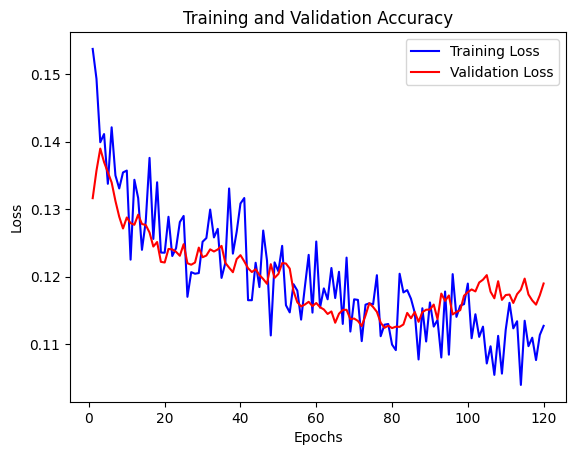

In [71]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy from the history object
train_acc = history.history['loss']
val_acc = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Loss')
plt.plot(epochs, val_acc, 'r', label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [121]:
pred_y = gnn_model.predict([left_graphs_test_tensor, left_adj_matrices_test_tensor,right_graphs_test_tensor,right_adj_matrices_test_tensor], batch_size=1)
    #[val_left_graphs_tensor,val_left_adj_matrices,val_right_graphs_tensor,val_right_adj_matrices],batch_size=1)

44/44 [==============================] - 0s 830us/step


In [185]:
val_input_tensors = [val_left_graphs,val_adj_matrices]

# Convert the input tensors to numpy arrays if they are not already
val_input_tensors = [np.array(tensor) if not isinstance(tensor, np.ndarray) else tensor for tensor in val_input_tensors]
pred_y = gnn_model.predict(val_input_tensors)

8/8 [==============================] - 0s 747us/step


In [61]:
pred_y[0]

array([1.0000000e+00, 2.0501820e-10, 3.0818928e-18], dtype=float32)

In [62]:
labels_ = []
for i,value in enumerate(pred_y):
    labels_.append(np.argmax(pred_y[i]))

In [109]:
np.argmax(labels_test_tensor,axis=1)

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [122]:
np.argmax(pred_y[:,:2],axis=1)

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report , f1_score

# Compute the confusion matrix
confusion_mat = confusion_matrix(np.argmax(labels_test_tensor, axis=1),np.argmax(pred_y[:,:2], axis=1))

# Compute the classification report
class_report = classification_report(np.argmax(labels_test_tensor, axis=1),np.argmax(pred_y[:,:2], axis=1))
print(class_report)


              precision    recall  f1-score   support

           0       0.57      0.59      0.58        22
           1       0.57      0.55      0.56        22

    accuracy                           0.57        44
   macro avg       0.57      0.57      0.57        44
weighted avg       0.57      0.57      0.57        44



 1/44 [..............................] - ETA: 1s

44/44 [==============================] - 0s 1ms/step


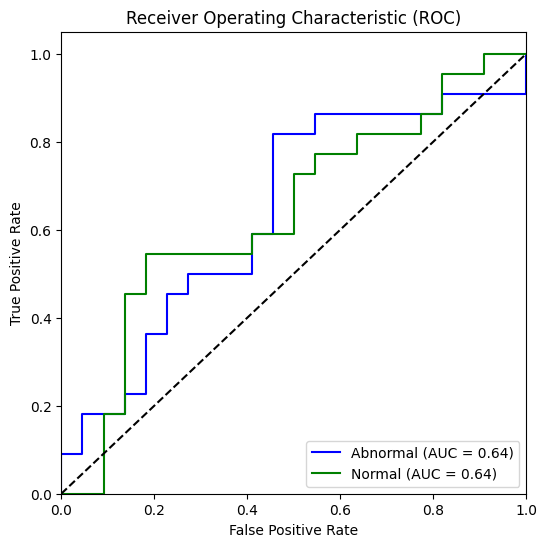

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score

# Assuming you have predictions and true labels for your validation data
predictions = gnn_model.predict([left_graphs_test_tensor, left_adj_matrices_test_tensor,right_graphs_test_tensor,right_adj_matrices_test_tensor], batch_size=1)
true_labels = labels_test_tensor

class_names = ['Abnormal','Normal']  # Replace with your actual class names

num_classes = predictions.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute average precision (AP) for each class
average_precision = {}

for i in range(num_classes):
    average_precision[i] = average_precision_score(true_labels[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 6))
colors = ['b', 'g', 'r', 'c', 'm']  # Change or add more colors as needed

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='%s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# plt.savefig('experiment/loss/log_AUC.png',dpi=300)
plt.show()


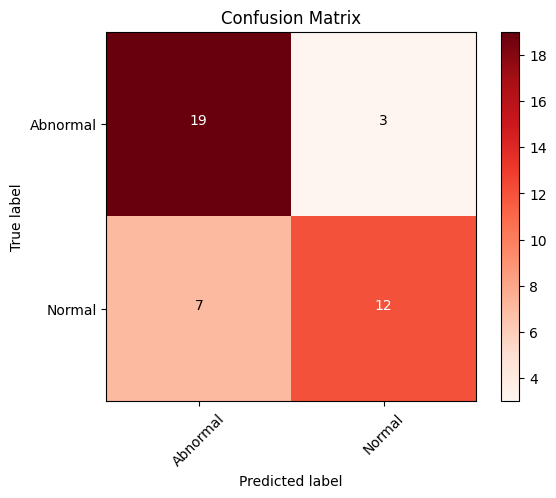

In [111]:
#Plot the confusion matrix
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
classes = ['Abnormal','Normal']  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix
cm_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Add text annotations
thresh = cm_norm.max() / 2.0
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, confusion_mat[i, j],
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
# plt.savefig('experiment/loss/_.png',dpi=300)
# Show the plot
plt.show()

 1/38 [..............................] - ETA: 0s

38/38 [==============================] - 0s 2ms/step


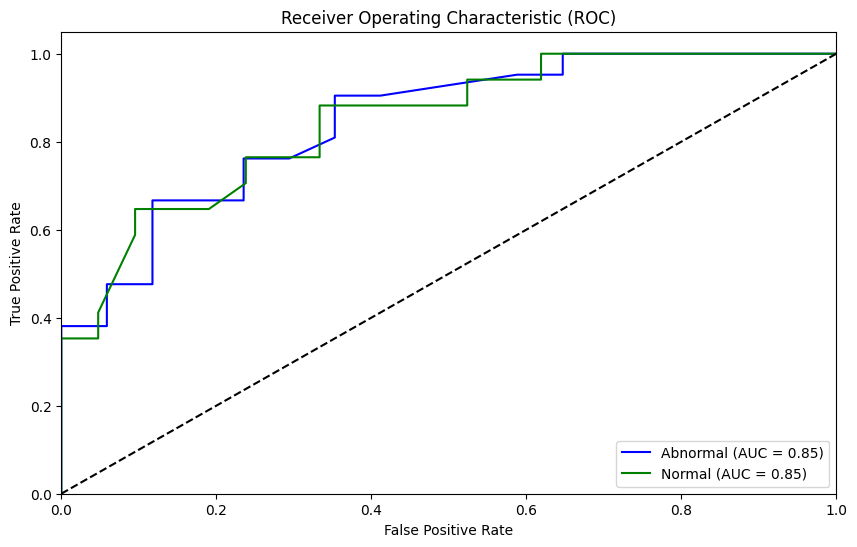

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score

# Assuming you have predictions and true labels for your validation data
predictions = gnn_model.predict([left_graphs_test_tensor, left_adj_matrices_test_tensor,right_graphs_test_tensor,right_adj_matrices_test_tensor], batch_size=1)
true_labels = labels_test_tensor

class_names = ['Abnormal','Normal']  # Replace with your actual class names

num_classes = predictions.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute average precision (AP) for each class
average_precision = {}

for i in range(num_classes):
    average_precision[i] = average_precision_score(true_labels[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm']  # Change or add more colors as needed

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='%s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# plt.savefig('experiment/loss/log_AUC.png',dpi=300)
plt.show()


# Plot average precision (AP) for each class
# plt.figure(figsize=(10, 6))

# for i in range(num_classes):
    # plt.bar(i, average_precision[i], color=colors[i], label='Class %d' % i)

# plt.xlabel('Class')
# plt.ylabel('Average Precision')
# plt.title('Average Precision (AP) - Multi-label Classification')
# plt.legend(loc="lower right")
# plt.xticks(np.arange(num_classes))
# plt.show()


For Hospital Data

In [76]:
gnn_model.save('models/Normal_gnn_with_DROPOUT_huberloss_trained_on_ILO_sms_hospital_nagaur_Hospital.h5')

In [ ]:
test_data = []
image_directory = 'hospital_segment/seg/0/'
dataset_images = os.listdir('hospital_segment/seg/0/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    test_data.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
test_df_0 = pd.DataFrame(test_data)
test_df_0['class_label'] = ['Normal']*test_df_0.shape[0] 

In [115]:
import pandas as pd
test_data = []
image_directory = 'hospital_segment/seg/1/'
dataset_images = os.listdir('hospital_segment/seg/1/')

# Iterate over the images in your dataset
for image_id in dataset_images:
    image_path = os.path.join(image_directory, image_id)
    
    feature_graphs = feature_graph(image_path)
    left_graph = feature_graphs[0]
    right_graph = feature_graphs[1]
    test_data.append({'image_id': image_path, 'left_graph': left_graph, 'right_graph': right_graph})
  
# Convert the list to a pandas DataFrame
test_df_1 = pd.DataFrame(test_data)
test_df_1['class_label'] = ['Abnormal']*test_df_1.shape[0] 

In [116]:
test_df = pd.concat([test_df_0,test_df_1])

In [151]:
test_df =  test_df.sample(frac=1).reset_index(drop=True)
test_df.head()

,image_id,left_graph,right_graph,class_label
0,hospital_segment/seg/0/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Normal
1,hospital_segment/seg/1/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal
2,hospital_segment/seg/0/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Normal
3,hospital_segment/seg/0/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Normal
4,hospital_segment/seg/1/1.2.392.200036.9125.9.0...,"(left_left_upper, left_left_middle, left_left_...","(right_left_upper, right_left_middle, right_le...",Abnormal


In [152]:
test_left_graphs, test_right_graphs, test_left_adj_matrices, test_right_adj_matrices = preprocess_graphs(test_df)
test_left_graphs_tensor= tf.convert_to_tensor(test_left_graphs)
test_left_adj_matrices = tf.convert_to_tensor(test_left_adj_matrices)
test_right_graphs_tensor = tf.convert_to_tensor(test_right_graphs)
test_right_adj_matrices = tf.convert_to_tensor(test_right_adj_matrices)

In [154]:
test_labels = preprocess_labels(test_df['class_label'])

['Abnormal' 'Normal']


In [52]:
pred_y = gnn_model.predict([test_left_graphs_tensor,test_left_adj_matrices,test_right_graphs_tensor,test_right_adj_matrices],batch_size=1)

36/36 [==============================] - 3s 86ms/step


In [185]:
gnn_model.save('gnn_model_with_TB_with_Regul,Dropout.h5')